In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import time
import random
import math
import numpy as np
import copy
import matplotlib.pyplot as plt
import numpy.matlib
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
from scipy.special import expit
from scipy.misc import imresize
import sys
sys.path.append('../code')
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [4]:
from hopfieldNetwork import hopfieldNet
from solverFile import solverClass
import numpy.matlib

In [5]:
ETA = 0.001 #learning rate
NTRAIN = 1000 #number of epochs
NUM_PATTERNS = 300 #number of patterns created
SPARSITY = 0.1 #number of zeros: e.g. SPARSITY = 0.1 means 10% ones and 90% zeros
IMAGE_SIZE = 10 #the size of our created pattern will be (IMAGE_SIZE x IMAGE_SIZE)
eval_f = 1 #evaluation frequency (every eval_f-th iteration) NOTE: currently not implemented
TRIALS = 1 #number of trials over which the results will be averaged in order to get smooth results
less_changed_weight_value = 0.00 #the learning rate of weights which are considered important have a learning
#rate of ETA * less_changed_weight_value
stored_patterns = 5 #number of patterns that are stored in the network before learning the new pattern
number_of_changed_values = 4500 #the number of weigths that are changed is 2*number_of_changed_values (The factor of 2
#is because of the symmetry of the weight matrix)
RUN_LOCAL = False #if False, the 3. and 4. in the description will be discarded for higher computational speed

## Find Approx

2
5
10
100


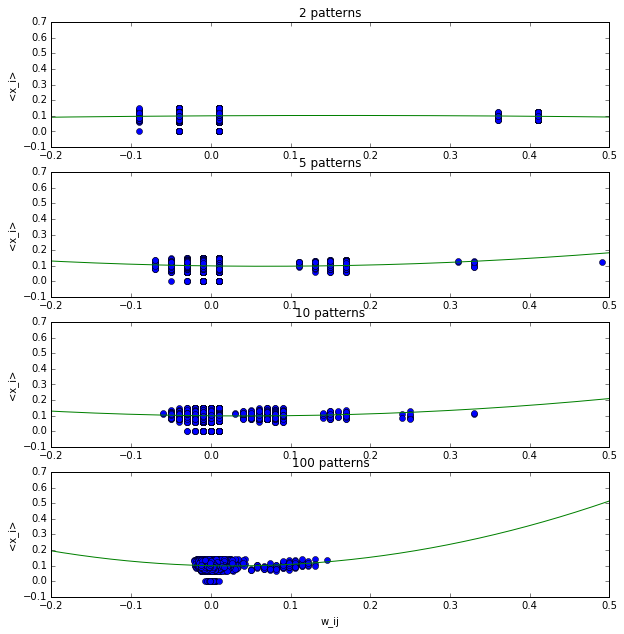

In [9]:
fig = plt.figure(figsize=(10,10.3))
numPat = [2,5,10,100]
num_iter = np.shape(numPat)[0]

for epoch in range(num_iter):#Loop over the four different numbers of stored patterns
    stored_patterns = numPat[epoch]
    print(stored_patterns)
    netFisher = hopfieldNet(IMAGE_SIZE, ETA, SPARSITY)
    solver = solverClass()
    patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, NUM_PATTERNS)
    mean_value = SPARSITY
    original_patterns = copy.deepcopy(patterns)
    patterns = patterns - mean_value
    p = np.zeros(shape=(IMAGE_SIZE**2, IMAGE_SIZE**2))
    for i in range(int(stored_patterns)):
        p += np.outer(patterns[:,i], patterns[:,i])
        netFisher.append_pattern(patterns[:,i], NTRAIN)
    w1 = p/stored_patterns
    mean_activations = np.mean(original_patterns, axis=1)
    mean_act_full = np.matlib.repmat(mean_activations, 100, 1)
    x = w1.flatten()
    y = mean_act_full.flatten()
    
    plt.subplot(num_iter,1,epoch+1)
    plt.plot(x,y,'o')
    
    f = np.linspace(-1,1,200)
    z = np.polyfit(x, y, 2)
    poly = np.poly1d(z)
    plt.plot(f,poly(f))
    
    plt.xlim((-0.2,0.5))
    plt.ylim((-0.1,0.7))
    plt.ylabel('<x_i>')
    a = copy.deepcopy(stored_patterns)
    plt.title('%i patterns'%a, fontsize=12)
plt.subplot(num_iter,1,num_iter)
plt.xlabel('w_ij')

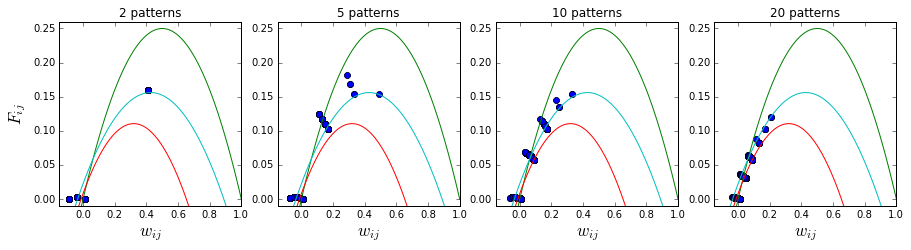

In [10]:
fig = plt.figure(figsize=(15,3.3))
numPat = [2,5,10,20]

for epoch in range(4):#Loop over the four different numbers of stored patterns
    stored_patterns = numPat[epoch]
    netFisher = hopfieldNet(IMAGE_SIZE, ETA, SPARSITY)
    solver = solverClass()
    patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, NUM_PATTERNS)
    mean_value = SPARSITY
    original_patterns = copy.deepcopy(patterns)
    patterns = patterns - mean_value
    p = np.zeros(shape=(IMAGE_SIZE**2, IMAGE_SIZE**2))
    for i in range(int(stored_patterns)):
        p += np.outer(patterns[:,i], patterns[:,i])
        netFisher.append_pattern(patterns[:,i], NTRAIN)
    w1 = p/stored_patterns
    
    ####### USE THIS WHEN WANTING TO APPLY THE FIT FOR ALL DIFFERENT NUMBERS OF PATTERNS SEPERATELY #######
    #mean_activations = np.mean(original_patterns, axis=1)
    #mean_act_full = np.matlib.repmat(mean_activations, 100, 1)
    #x1 = w1.flatten()
    #y1 = mean_act_full.flatten()
    #z1 = np.polyfit(x1, y1, 2)
    #poly = np.poly1d(z1)

    netFisher.set_weights(w1)
    overall_error = 0
    for i in range(int(stored_patterns)):
        netFisher.present_pattern(original_patterns[:,i])
        netFisher.step(100)
        output = netFisher.s
        error = np.sum(original_patterns[:,i]-output)**2
        overall_error += error
    netFisher.calculate_fisher_information(patterns[:,0:stored_patterns])
    
    ############### IMPORTANT STUFF BEGINS HERE ##################
    x = w1.flatten()
    y = netFisher.curvature.flatten()
    max_value_w = (1-SPARSITY)**2*stored_patterns
    z = np.linspace(-0.5,1,100)
    theoretical = z - z**2 #Theoretical result for s=0
    plt.xlabel(r'$w_{ij}$', fontsize=17)
    a = copy.deepcopy(stored_patterns)
    plt.subplot(1,4,epoch+1)
    plt.title('%i patterns'%a, fontsize=12)
    plt.plot(x,y, 'o')
    #plt.plot(x,f, 'o')
    plt.plot(z,theoretical)
    s = SPARSITY
    sum_value_1 = np.matlib.repmat(np.mean(patterns[:,0:stored_patterns], axis = 1), 100, 1)
    sum_value_2 = np.transpose(sum_value_1)
    sum_value = sum_value_1 + sum_value_2
    sum_value = 2*poly(z)
    #MICHAEL's Version when NOT assuming mean(x_i) = 0
    F_ij_term1 = (1-2*s)**2*z + s*(1-s)*(1-2*s)*(sum_value) + s**2 * (1-s)**2
    F_ij = F_ij_term1 - z**2
    F_flattened = F_ij.flatten()

    
    #MICHAEL's Version when assuming mean(x_i) = 0
    F_ij_term1_0 = (1-2*s)**2*z + s*(1-s)*(1-2*s)*(0) + s**2 * (1-s)**2
    F_ij_term1_0_full = F_ij_term1_0 - z**2
    #MICHAEL's Version when assuming mean(x_i) = 0, just in a different way to write it down. Same as above
    F_ij_term2 = s**2*(1-s)**2+(1-2*s)**2*z-z**2
    
    #Choose the plots you need here
    plt.plot(z,F_ij_term1_0_full)
    plt.plot(z,F_flattened)
    #plt.plot(z,F_ij_term2)
    #plt.plot(x,F_flattened,'o')
    plt.xlabel(r'$w_{ij}$', fontsize=17)
    plt.ylim(-0.01,0.26)
    plt.xlim(-0.15,1)

plt.subplot(1,4,1)
plt.ylabel(r'$F_{ij}$', fontsize=17)
plt.show()